記得跑import及函式設定

* 目錄
  * 2. 預備知識
    * 2.2 數據操作
      * GPU操作
    * 2.3 自動求梯度
  * 3. 深度學習基礎
    * 3.1 基本要素
    * 3.2 線性回歸從零實現
      * 讀取數據->初始化模型參數->定義模型(映射函數)->
      * 定義損失函數->定義優化算法->訓練模型(loss、backward、optimize、梯度記得清零)
    * 3.3 線性回歸簡潔實現
    * 3.4 softmax回歸
    * 3.5 圖像分類數據集
    * 3.6 從零實現softmax
    * 3.7 sofmax回歸簡潔實現
    * 3.8 多層感知機
      * 激活函數的微分
    * 3.9 多層感知機從零實現
    * 3.10 多層感知機簡潔實現
    * 3.11 模型選擇、欠擬合和過擬合
      * 畫epochs~loss圖
    * 3.12 權重衰減
    * 3.13 丟棄法
      * 其他丟棄法？
    * 3.14 正向傳播、反向傳播和計算圖
    * 3.15 數值穩定性和模型初始化
      * 其他初始化？
    * 3.16 房價預測Kaggle
  * 10.
    * 10.3 Word2Vec實現
    * 10.7 文本情感分類


In [3]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 17279 (delta 26), reused 24 (delta 5), pack-reused 17185
Receiving objects: 100% (17279/17279), 185.25 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (12056/12056), done.


In [5]:
import torch
import numpy as np

%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import random

import torch.utils.data as Data

import torch.nn as nn
from torch.nn import init

import torch.optim as optim
from collections import OrderedDict


import torchvision
import torchvision.transforms as transforms
import time
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
# import d2lzh_pytorch as d2l

import torchtext.vocab as Vocab
import os
from tqdm import tqdm
import tarfile
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT = "/S1/CSCL/tangss/Datasets"


In [ ]:
#讀取數據函式
def load_data_fashion_mnist(batch_size):
  mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
  mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
  
  if sys.platform.startswith('win'):
    num_workers = 0
  else:
    num_workers = 4
  train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle = True, num_workers = num_workers)
  test_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle = True, num_workers = num_workers)
  return train_iter, test_iter

def sgd(params, lr, batch_size):
  for param in params:
    param.data -= lr* param.grad / batch_size

def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0.0, 0
  for X, y in data_iter:
    acc_sum = (net(X).argmax(dim=1)==y).float().sum()
    n += y.shape[0]
  return acc_sum / n

#迭代訓練函式
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0.0
    for X, y in train_iter:
      y_hat = net(X)
      l = loss(y_hat, y).sum()

      if optimizer is not None:
        optimizer.zero_grad()
      elif params is not None and params[0].grad is not None:
        for param in params:
          param.grad.data.zero_()

      l.backward()
      if optimizer is None:
        sgd(params, lr, batch_size)
      else:
        optimizer.step()

      train_l_sum += l
      train_acc_sum += (y_hat.argmax(dim=1)==y).float().sum().item()
      n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' %(epoch +1, train_l_sum/n, train_acc_sum/n, test_acc))



2.2 數據操作


In [ ]:
x1 = torch.empty(5,3)
print(x1)
x2 = torch.rand(5,3)
print(x2)
x3 = torch.zeros(5,3,dtype=torch.long)
print(x3)
x4 = torch.tensor([5.5,3])
print(x4)
x4 = x4.new_ones(5,3,dtype=torch.float64)
print(x4)
x4 = torch.randn_like(x, dtype=torch.float)
print(x4)

print(x.size(), x.shape)

tensor([[5.3162e-36, 0.0000e+00, 1.6675e-43],
        [5.6052e-44, 1.6816e-43, 6.1657e-44],
        [4.4842e-44, 1.6956e-43, 6.1657e-44],
        [4.4842e-44, 1.7096e-43, 5.7453e-44],
        [2.4412e-01, 4.5539e-02, 8.8363e-01]])
tensor([[0.8543, 0.7152, 0.4805],
        [0.8607, 0.9551, 0.3190],
        [0.9568, 0.9721, 0.1748],
        [0.2082, 0.0964, 0.2973],
        [0.8589, 0.4328, 0.3204]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([5.5000, 3.0000])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[-1.5582,  0.3919,  0.1761],
        [-1.1948,  0.5432,  0.2479],
        [ 0.3745, -1.2932,  0.1656],
        [-0.7284,  1.5078,  2.4543],
        [-0.0103,  0.9628,  1.2336]])
torch.Size([5, 3]) torch.Size([5, 3])


In [ ]:
y =  torch.rand(5,3)
z = 3
print(y+x)
print(torch.add(x,y))

result = torch.empty(5,3)
torch.add(x,y,out=result)
print(result)

y.add_(x)
print(y)

tensor([[9.3930e-01, 1.2744e-01, 4.4609e-02],
        [4.4450e-01,        nan, 9.0541e-01],
        [1.1578e+27, 1.1362e+30, 7.1547e+22],
        [4.5828e+30, 1.2121e+04, 7.1846e+22],
        [2.4639e-01, 7.0374e+22, 4.7366e-01]])
tensor([[9.3930e-01, 1.2744e-01, 4.4609e-02],
        [4.4450e-01,        nan, 9.0541e-01],
        [1.1578e+27, 1.1362e+30, 7.1547e+22],
        [4.5828e+30, 1.2121e+04, 7.1846e+22],
        [2.4639e-01, 7.0374e+22, 4.7366e-01]])
tensor([[9.3930e-01, 1.2744e-01, 4.4609e-02],
        [4.4450e-01,        nan, 9.0541e-01],
        [1.1578e+27, 1.1362e+30, 7.1547e+22],
        [4.5828e+30, 1.2121e+04, 7.1846e+22],
        [2.4639e-01, 7.0374e+22, 4.7366e-01]])
tensor([[9.3930e-01, 1.2744e-01, 4.4609e-02],
        [4.4450e-01,        nan, 9.0541e-01],
        [1.1578e+27, 1.1362e+30, 7.1547e+22],
        [4.5828e+30, 1.2121e+04, 7.1846e+22],
        [2.4639e-01, 7.0374e+22, 4.7366e-01]])


In [ ]:
y = x[0, :]
y += 1 
print(x)
print(y)
print(x[0, :])

y = x.view(15)
z = x.view(-1,5)
print(x.size(), y.size(), z.size())

x_cp = x.clone().view(15)
x -= 1
print(x)
print(x_cp)

x = torch.randn(1)
x1 = torch.rand(1) 
# randn()從常態分佈裡隨機抽取 rand()從均勻分布裡隨機抽取
print(x,x1)
print(x.item())

tensor([[ 9.0000e+00,  9.0000e+00,  9.0000e+00],
        [-1.0000e+00,         nan, -1.0000e+00],
        [ 1.1578e+27,  1.1362e+30,  7.1547e+22],
        [ 4.5828e+30,  1.2120e+04,  7.1846e+22],
        [-1.0000e+00,  7.0374e+22, -1.0000e+00]])
tensor([9., 9., 9.])
tensor([9., 9., 9.])
torch.Size([5, 3]) torch.Size([15]) torch.Size([3, 5])
tensor([[ 8.0000e+00,  8.0000e+00,  8.0000e+00],
        [-2.0000e+00,         nan, -2.0000e+00],
        [ 1.1578e+27,  1.1362e+30,  7.1547e+22],
        [ 4.5828e+30,  1.2119e+04,  7.1846e+22],
        [-2.0000e+00,  7.0374e+22, -2.0000e+00]])
tensor([ 9.0000e+00,  9.0000e+00,  9.0000e+00, -1.0000e+00,         nan,
        -1.0000e+00,  1.1578e+27,  1.1362e+30,  7.1547e+22,  4.5828e+30,
         1.2120e+04,  7.1846e+22, -1.0000e+00,  7.0374e+22, -1.0000e+00])
tensor([0.3952]) tensor([0.1866])
0.3952113389968872


In [ ]:
#廣播機制：形狀不同的tensor會先複製成同一個形狀
x = torch.arange(1,3).view(1,2)
print(x)
y = torch.arange(1,4).view(3,1)
print(y)
print(x+y)

#運算的內存開銷
x = torch.tensor([1,2])
y = torch.tensor([3,4])
id_bf = id(y)
y = y+x #这样的运算是会新开内存的，然后将y指向新内存
print(id(y) == id_bf)

x = torch.tensor([1,2])
y = torch.tensor([3,4])
id_bf = id(y)
y[:] = y+x #torch.add(x,y,out=y) || y += x
print(id(y) == id_bf)

#view返回的tensor雖然共享data，但指向的記憶體是不一樣的，因為Tensor除了data以外還有些屬性

tensor([[1, 2]])
tensor([[1],
        [2],
        [3]])
tensor([[2, 3],
        [3, 4],
        [4, 5]])
False
True


In [ ]:
#numpy tensor轉換是共享內存的，所以速度才很快，改數據也要小心
#所有在CPU上的Tensor（除了CharTensor）都支持与NumPy数组相互转换。

a = torch.ones(5)
b = a.numpy()
print(a,b)
a+=1
print(a,b)
b+=1
print(a,b)

a = np.ones(5)
b = torch.from_numpy(a)
print(a,b)
a+=1
print(a,b)
b+=1
print(a,b)

c = torch.tensor(a) #這個轉tensor會先copy
a += 1
print(a,c)

tensor([1., 1., 1., 1., 1.]) [1. 1. 1. 1. 1.]
tensor([2., 2., 2., 2., 2.]) [2. 2. 2. 2. 2.]
tensor([3., 3., 3., 3., 3.]) [3. 3. 3. 3. 3.]
[1. 1. 1. 1. 1.] tensor([1., 1., 1., 1., 1.], dtype=torch.float64)
[2. 2. 2. 2. 2.] tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
[3. 3. 3. 3. 3.] tensor([3., 3., 3., 3., 3.], dtype=torch.float64)
[4. 4. 4. 4. 4.] tensor([3., 3., 3., 3., 3.], dtype=torch.float64)


GPU操作

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  y = torch.ones_like(x, device=device) #創在GPU上
  x = x.to(device)
  z = x + y
  print(z)
  print(z.to("cpu", torch.double)) #to()還可以改變數據類型


tensor([2, 3], device='cuda:0')
tensor([2., 3.], dtype=torch.float64)


2.3 自動求梯度
* torch.autograd这个包就是用来计算一些雅克比矩阵的乘积
* 雅可比矩阵（Jacobian matrix）向量y對向量x的梯度，其中y可表示為f(x)

In [ ]:
x = torch.ones(2,2,requires_grad=True)
print(x)
print(x.grad_fn) 
#该属性即创建该Tensor的Function, 
#就是说该Tensor是不是通过某些运算得到的，
#若是，则grad_fn返回一个与这些运算相关的对象，否则是None。

y = x+2
print(y)
print(y.grad_fn)

#像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None。
print(x.is_leaf, y.is_leaf)

z = y * y * 3
out = z.mean()
print(z, out)

a = torch.randn(2,2) # 缺失情况下默认 requires_grad = False
a = ((a*3)/(a-1))
print(a.requires_grad)
# a.requires_grad = True
a.requires_grad_(True)
print(a.requires_grad)
b = (a*a).sum()
print(b.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
True False
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
False
True


In [ ]:
print(x.grad)
# 因为out是一个标量，所以调用backward()时不需要指定求导变量：
out.backward() # 等价于 out.backward(torch.tensor(1.)) 其中1.為x的值
print(x.grad) #d(out)/dx 
# out = 1/4 * (3(x11+2)^2 + 3(x12+2)^2 + 3(x21+2)^2 + 3(x22+2)^2)
# d(out)/dx11 , d(out)/dx12
# d(out)/dx21 , d(out)/dx22

out2 = x.sum()
# out2 = x11 + x12 + x21 + x22
out2.backward()
print(x.grad) 
# 4.5 + 1 , 4.5 + 1
# 4.5 + 1 , 4.5 + 1
# 注意：grad在反向传播过程中是累加的(accumulated)，
# 这意味着每一次运行反向传播，梯度都会累加之前的梯度，
# 所以一般在反向传播之前需把梯度清零。

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

None
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  


* **为什么在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同形的Tensor? **
<br>简单来说就是为了避免向量（甚至更高维张量）对张量求导，而转换成标量对张量求导

* **向量對張量求導的问题：**
<br>怎样反向传播？怎样将两个四维张量相乘？？？这要怎么乘？？？就算能解决两个四维张量怎么乘的问题，四维和三维的张量又怎么乘？导数的导数又怎么求

* **標量：**
<br>物理學中，標量（或作純量）指在坐標變換下保持不變的物理量。
* **張量：**
<br>一些向量空間和一些對偶空間的笛卡兒積上的多重線性映射


In [ ]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
y = 2*x
z = y.view(2,2)
print(z)

#Z不是一個標量，在调用backward时需要传入一个和z同形的权重向量进行加权求和得到一个标量。
v = torch.tensor([[1.0, 0.1], [0.01, 0.001]], dtype=torch.float)
#z.backward() #Z不是一個標量，會error
z.backward(v) #用z同樣的形狀向量v去求導，然後再對回x
# z:
# 2*x11 , 2*x12
# 2*x21 , 2*x22

# 對v求導
# 2*(v11=1.0) , 2*(v12=0.1)
# 2*(v21=0.01) , 2*(v22=0.001)
print(x.grad) 

tensor([[2., 4.],
        [6., 8.]], grad_fn=<ViewBackward>)
tensor([2.0000, 0.2000, 0.0200, 0.0020])


In [ ]:
x = torch.tensor(2.0, requires_grad=True)
y1 = x ** 2
with torch.no_grad():
  y2 = x ** 3
y3 = y1 + y2

print(x.requires_grad)
print(y1, y1.requires_grad)
print(y2, y2.requires_grad)
print(y3, y3.requires_grad)

y3.backward()
print(x.grad) #不會包含y2的求導值

True
tensor(4., grad_fn=<PowBackward0>) True
tensor(8.) False
tensor(12., grad_fn=<AddBackward0>) True
tensor(4.)


In [ ]:
#如果我们想要修改tensor的数值，但是又不希望被autograd记录
#（即不会影响反向传播），那么我么可以对tensor.data进行操作。
x = torch.ones(1, requires_grad=True)

print(x.data) #還是一個tensor
print(x.data.requires_grad) #但已獨立於計算圈之外

y = 2*x
x.data *= 100
y.backward()
print(x)
print(x.grad)


tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])


3. 深度學習基礎
<br>3.1 基本要素：模型（映射函數）、训练数据、损失函数（目標函數）和优化算法
<br>3.2 線性回歸從零實現

※3.1用矢量計算速度快很多

In [ ]:
%matplotlib inline
import torch, numpy as np
from IPython import display
import matplotlib.pyplot as plt
import random

tensor([-0.4243, -0.2323]) tensor(3.4484)
tensor([[ 0.5142, -1.7505],
        [ 0.9974, -0.5763],
        [-1.6741,  0.2221],
        [-1.6049, -1.6768],
        [-0.3716,  0.0129],
        [-1.3609, -0.6822],
        [-0.4428,  2.6375],
        [-0.0914,  0.5835],
        [-0.6759, -0.3569],
        [ 1.3395, -0.1175]]) tensor([11.1499,  8.1621,  0.0833,  6.6862,  3.4233,  3.8148, -5.6557,  2.0333,
         4.0584,  7.2848])
epoch 1, loss 0.045890
epoch 2, loss 0.000187
epoch 3, loss 0.000050


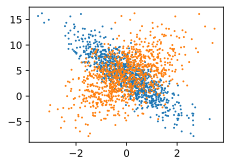

In [ ]:
#3.2.1生成數據集
num_inputs = 2 #2個feature
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
true_labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
true_labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)
#加上噪聲干擾
print(features[0], labels[0])

def use_svg_display():
  display.set_matplotlib_formats('svg') #向量縮放圖，比點陣圖多很多優點
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), true_labels.numpy(), 1)
plt.scatter(features[:, 0].numpy(), true_labels.numpy(), 1)

# 3.2.2 读取数据
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices) # 样本的读取顺序是随机的
  for i in range(0, num_examples, batch_size):
    j = torch.LongTensor(indices[i:min( i+batch_size, num_examples)]) # 最后一次可能不足一个batch
    yield features.index_select(0,j), labels.index_select(0,j)

batch_size = 10
for X, y in data_iter(batch_size, features, true_labels):
  print(X,y)
  break

# 3.2.3 初始化模型参数
w = torch.tensor(np.random.normal(0,0.01,(num_inputs, 1)), dtype = torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)
# w.requires_grad_(requires_grad=True)

# 3.2.4 定义模型
def linreg(X, w, b):
  return torch.mm(X, w)+b

# 3.2.5 定义损失函数
# 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
def squared_loss(y_hat, y):
  return (y_hat - y.view(y_hat.size())) **2 /2

# 3.2.6 定义优化算法
# param.grad: loss對指定param(標量)求導後的值
# 注意这里更改param时用的param.data
def sgd(params, lr, batch_size):
  for param in params:
    param.data -= lr * param.grad / batch_size

# 3.2.7 训练模型
#迭代周期个数num_epochs和学习率lr都是超参数
#在实践中，大多超参数都需要通过反复试错来不断调节。
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, true_labels):
    l = loss(net(X, w, b), y).sum() #l本來不是標量，sum()以後就變標量
    l.backward()
    sgd([w, b], lr, batch_size)

    w.grad.data.zero_() #更新完參數後要清零梯度，再更新一次時才不會累加上去
    b.grad.data.zero_()
  train_l = loss(net(features, w, b), true_labels)
  print('epoch %d, loss %f' %(epoch+1, train_l.mean().item()))

In [ ]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9998],
        [-3.3996]], requires_grad=True)
4.2 
 tensor([4.2001], requires_grad=True)


3.3 線性回歸簡潔實現
* 注意：torch.nn仅支持输入一个batch的样本不支持单个样本输入，如果只有单个样本，可使用input.unsqueeze(0)来添加一维。

In [ ]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

#3.3.2讀取數據
import torch.utils.data as Data

batch_size = 10

dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

import torch.nn as nn
#3.3.3定義模型
class LinearNet(nn.Module):
  def __init__(self, n_feature):
    super().__init__()
    self.linear = nn.Linear(n_feature, 1)

  def forward(self, x):
    y = self.linear(x)
    return y

net = LinearNet(num_inputs)
print(net)
# #其他寫法
# #寫法一
# net = nn.Sequential(
#     nn.Linear(num_inputs, 1)
# )
# #寫法二
# net = nn.Sequential()
# net.add_module('linear', nn.Linear(num_inputs, 1))
# # 寫法三
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
#   ('linear', nn.Linear(num_inputs, 1))                               
# ]))
#print(net, net[0])

for param in net.parameters():
  print(param)

#3.3.4初始化模型參數
from torch.nn import init
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)
# 也可以直接修改bias的data: net[0].bias.data.fill_(0)

#3.3.5定義損失函數
loss = nn.MSELoss()

#3.3.6定義優化算法
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)
# #我们还可以为不同子网络设置不同的学习率，这在finetune时经常用到。例：
# optimizer = optim.SGE([
#   # 如果对某个参数不指定学习率，就使用最外层的默认学习率
#   {'params':net.subnet1.parameters()},
#   {'params':net.subnet2.parameters(), 'lr':0.01}
# ], lr = 0.03)
# # 邊訓練邊調整學習率
# for param_group in optimizer.param_groups:
#   param_group['lr'] *= 0.1
# 另一种是更简单也是较为推荐的做法——新建优化器，
# 由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。
# 但是后者对于使用动量的优化器（如Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

#3.3.7訓練模型
num_epochs = 10
for epoch in range(1, num_epochs+1):
  for X, y in data_iter:
    l = loss(net(X), y.view(-1,1))
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
  print('epoch %d, loss: %f' % (epoch, l.item()))

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Parameter containing:
tensor([[-0.4663,  0.1217]], requires_grad=True)
Parameter containing:
tensor([0.0244], requires_grad=True)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)
epoch 1, loss: 0.000180
epoch 2, loss: 0.000068
epoch 3, loss: 0.000074
epoch 4, loss: 0.000046
epoch 5, loss: 0.000032
epoch 6, loss: 0.000087
epoch 7, loss: 0.000053
epoch 8, loss: 0.000140
epoch 9, loss: 0.000036
epoch 10, loss: 0.000087


In [ ]:
print(true_w, net.linear.weight)
print(true_b, net.linear.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0005, -3.4002]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1996], requires_grad=True)


3.4 softmax回歸
* 輸出單元從回歸中的一個變成多個
* softmax運算使輸出更適合離散值
  * 连续值到离散值的转化通常会影响到分类质量
  * 把隨機輸出每個元素變成了非負數，且每一個樣本之各類別機率總合為1
* 分類模型
* 損失函數：交叉商
  * 平方損失過於嚴格，要求對應的類別計算完必須=1，但其實只要大於其他項就好
  * 平方損失收斂速度太慢
  * 平方損失收斂不平均(非凸函數)
  * true_label中只有一個類別的值為1，其他均為0(0,1,0,0,0)
  * 所以交叉商  $-\sum_{i=1}^{n}{y_j^{(i)}\log \hat y_j^{(i)}}$ 可簡化為 —$\sum_{i=1}^{n}{\log \hat y_{y^{(i)}}^{(i)}}$
  * 其中n為樣本數，表示對於每個樣本而言，只有true_label為1的對應項目會留在交叉商中，其他都會消失
  * 交叉商適合衡量兩個概率分布的差異，當每個樣本的y_true = y_hat時，交叉商為0


3.5 圖像分類數據集
* transforms.ToTensor()将
  1. 尺寸为 (H x W x C) 且数据位于[0, 255]的PIL图片
  2. 数据类型为np.uint8的NumPy数组
* 转换为
  1. 尺寸为(C x H x W)
  2. 数据类型为torch.float32
  3. 位于[0.0, 1.0]
* 的Tensor。

<br>
注意： 由于像素值为0到255的整数，所以刚好是uint8所能表示的范围，包括transforms.ToTensor()在内的一些关于图片的函数就默认输入的是uint8型，若不是，可能不会报错但可能得不到想要的结果。所以，如果用像素值(0-255整数)表示图片数据，那么一律将其类型设置成uint8，避免不必要的bug。
<br><br>
在实践中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。PyTorch的DataLoader中一个很方便的功能是允许使用多进程来加速数据读取。这里我们通过参数num_workers来设置4个进程读取数据。

In [ ]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000
torch.Size([1, 28, 28]) 9


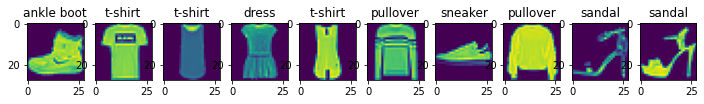

In [ ]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))
feature, label = mnist_train[0]
print(feature.shape, label) #C x H x W

# 可將數值標籤轉換成相應文本標籤的函數
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

# 可在一行內畫出多張圖像和對應標籤的函數
def show_fashion_mnist(images, labels):
  _, figs = plt.subplots(1, len(images), figsize=(12,12))
  for f , img, lbl in zip(figs, images, labels):
    f.imshow(img.view((28, 28)).numpy())
    f.set_title(lbl)
    f.axes.get_xaxis().set_visible(True)
    f.axes.get_yaxis().set_visible(True)
  plt.show()

X, y = [],[]
for i in range(10):
  X.append(mnist_train[i][0])
  y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))


3.6 從零實現softmax
* a.gather(b)：從a的每列中取出取出b值(true_label之索引)對應的值
* y_hat.argmax(dim=1)返回矩阵y_hat每行中最大元素的索引

In [ ]:
#3.5.2讀取小批量
batch_size = 256
if sys.platform.startswith('win'):
  num_workers = 0
else:
  num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle = True, num_workers = num_workers)
test_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle = True, num_workers = num_workers)

#3.6.2初始化模型參數
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float, requires_grad=True)
b = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)

#3.6.3實現softmax運算 
#對同一行dim=0 同一列dim=1 的元素求和
def softmax(X):
  X_exp = X.exp()
  partition = X_exp.sum(dim=1,keepdim=True)
  return X_exp/partition #使用廣播機制

#3.6.4定義模型
def net(X):
  return softmax(torch.mm(X.view((-1, num_inputs)),W) + b)

#3.6.5定義損失函數
def cross_entropy(y_hat, y):
  return -torch.log(y_hat.gather(1,y.view(-1,1)))

#3.6.5.2定義優化算法
def sgd(params, lr, batch_size):
  for param in params:
    param.data -= lr*param.grad / batch_size

#3.6.6計算分類準確率
def accuracy(y_hat, y):
  return (y_hat.argmax(dim=1)==y).float().mean().item()

def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0.0, 0
  for X, y in data_iter:
    acc_sum = (net(X).argmax(dim=1)==y).float().sum()
    n += y.shape[0]
  return acc_sum / n

#3.6.7訓練模型
num_epochs = 5
lr = 0.1
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0.0
    for X, y in train_iter:
      y_hat = net(X)
      l = loss(y_hat, y).sum()

      if optimizer is not None:
        optimizer.zero_grad()
      elif params is not None and params[0].grad is not None:
        for param in params:
          param.grad.data.zero_()

      l.backward()
      if optimizer is None:
        sgd(params, lr, batch_size)
      else:
        optimizer.step()

      train_l_sum += l
      train_acc_sum += (y_hat.argmax(dim=1)==y).float().sum().item()
      n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' %(epoch +1, train_l_sum/n, train_acc_sum/n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W,b], lr)



epoch 1, loss 0.7881, train acc 0.748, test acc 0.001
epoch 2, loss 0.5709, train acc 0.813, test acc 0.001
epoch 3, loss 0.5265, train acc 0.825, test acc 0.001
epoch 4, loss 0.5011, train acc 0.831, test acc 0.001
epoch 5, loss 0.4854, train acc 0.837, test acc 0.001


3.7 sofmax回歸簡潔實現

In [ ]:
# 3.7.1讀取數據
# 同3.5

# 3.7.2定義和初始化模型
num_inputs = 784
num_outpus = 10
#定義方法一
class LinearNet(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super().__init__()
    self.linear = nn.Linear(num_inputs, num_outpus)
  def forward(self, x): #x shape: (batch_size, 1, 28, 28)
    y = self.linear(x.view(x.shape[0], -1))
    return y

net = LinearNet(num_inputs, num_outpus)
#定義方法二
class FlattenLayer(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x.view(x.shape[0], -1)

net = nn.Sequential(OrderedDict([
                                 ('flatten', FlattenLayer()),
                                 ('linear', nn.Linear(num_inputs, num_outputs))
]))

init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

# 3.7.3softmax和交叉熵損失函數
loss = nn.CrossEntropyLoss()

# 3.7.4定義優化算法
optimizer = torch.optim.SGD(net.parameters(), lr =0.1)

# 3.7.5訓練模型
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.750, test acc 0.001
epoch 2, loss 0.0022, train acc 0.812, test acc 0.001
epoch 3, loss 0.0021, train acc 0.826, test acc 0.001
epoch 4, loss 0.0020, train acc 0.832, test acc 0.001
epoch 5, loss 0.0019, train acc 0.837, test acc 0.001


3.8 多層感知機
  * ReLU:rectified linear unit
  * detach()是用來分離require_grad=True的Tensor， 

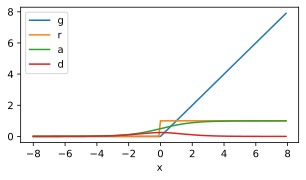

In [ ]:
def use_svg_display():
  display.set_matplotlib_formats('svg') #向量縮放圖，比點陣圖多很多優點
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  plt.rcParams['figure.figsize'] = figsize

def xyplot(x_vals, y_vals, name):
  set_figsize(figsize=(5,2.5))
  plt.plot(x_vals.detach(), y_vals.detach())
  plt.xlabel('x')
  # plt.ylabel(name + 'x')
  plt.legend(name + '(x)')

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x,y,'relu')

y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

y = x.sigmoid()
xyplot(x, y, 'sigmoid')

x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')


3.9 多層感知機從零實現


In [ ]:
#3.9.1讀取數據
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

#3.9.2定義模型參數

num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype = torch.float ,requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype = torch.float ,requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype = torch.float ,requires_grad=True)
b2 = torch.zeros(num_outputs, dtype = torch.float ,requires_grad=True)

params = [W1,b1,W2,b2]
# for param in params:
#   param.requires_grad_(requires_grad=True)

#3.9.3定義激活函數
def relu(x):
  return torch.max(input=x, other=torch.tensor(0.0))

#3.9.4定義模型
def net(X):
  X = X.view((-1, num_inputs))
  H = relu(torch.matmul(X,W1)+b1)
  return torch.matmul(H,W2)+b2
#3.9.5定義損失函數
loss = nn.CrossEntropyLoss()

#3.9.6訓練模型
num_epochs, lr = 5, 100
train_ch3(net, train_iter, test_iter, loss, num_epochs,batch_size, params, lr)

epoch 1, loss 0.0031, train acc 0.708, test acc 0.001
epoch 2, loss 0.0019, train acc 0.823, test acc 0.001
epoch 3, loss 0.0017, train acc 0.844, test acc 0.001
epoch 4, loss 0.0015, train acc 0.855, test acc 0.001
epoch 5, loss 0.0015, train acc 0.862, test acc 0.001


3.10 多層感知機簡潔實現

In [ ]:

class FlattenLayer(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x.view(x.shape[0], -1)
    
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

for params in net.parameters():
  init.normal_(params, mean=0, std=0.01)

batch_size=256
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)


epoch 1, loss 0.0031, train acc 0.704, test acc 0.001
epoch 2, loss 0.0019, train acc 0.819, test acc 0.001
epoch 3, loss 0.0017, train acc 0.843, test acc 0.001
epoch 4, loss 0.0015, train acc 0.855, test acc 0.001
epoch 5, loss 0.0014, train acc 0.866, test acc 0.001


3.11模型選擇、欠擬合和過擬合
  * 模型選擇：選擇不同類模型／同類但有不同超參數(隱藏層or單元數、激活函數...)
    * 驗證數據集：可用來選擇模型
    * 測試數據集：理想上只能在所有超參數／模型參數選定後使用一次，用於鑑定模型表現，不可用來選擇模型
      * 但因數據成本高，測試數據很少用一次就丟，跟驗證數據集的界線較模糊
    * KFold：訓練數據不夠用時留驗證數據集太奢侈，所以誕生。
  * 訓練誤差vs泛化誤差
    * 機器學習的最終目的在降低泛化誤差
    * 但模型的訓練、損失函數及優化器都在降低訓練誤差
  * 欠擬合vs過擬合
    * 當模型無法得到較低的訓練誤差
    * 當訓練誤差變低但泛化誤差卻變大
    * 影響兩主因：模型複雜度、訓練數據集大小
      * 模型複雜度：參數多寡。複雜度高->過擬合
      * 訓練數據集過少(比模型參數少時) -> 過擬合

torch.Size([200, 1]) torch.Size([200, 3])
final epoch: train loss 5.603055866498785e-11 test loss 8.724782701863276e-11


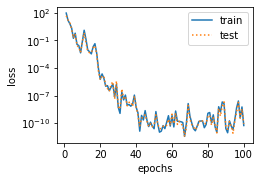

In [ ]:
# 生成數據集
# y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + e(噪聲)
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train+n_test, 1))
poly_features = torch.cat((features, torch.pow(features,2),torch.pow(features,3)),1)
#dim=0 => 600x1, dim=1 =>200x3 可用col index
print(features.shape, poly_features.shape)
labels = (true_w[0]*poly_features[:,0] + true_w[1]*poly_features[:,1] +true_w[2]*poly_features[:,2] + true_b)
torch.tensor(np.random.normal(0,0.01, size=labels.size()), dtype=torch.float)

#定義作圖函數
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
  plt.rcParams['figure.figsize'] = figsize
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.semilogy(x_vals, y_vals)
  if x2_vals and y2_vals:
    plt.semilogy(x2_vals, y2_vals, linestyle = ':')
    plt.legend(legend)

def ploty(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
  plt.rcParams['figure.figsize'] = figsize  
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.plot(x_vals, y_vals)
  if x2_vals and y2_vals:
    plt.plot(x2_vals, y2_vals, linestyle = ':')
    plt.legend(legend)

#訓練模型
num_epochs, loss = 100, nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
  net = nn.Linear(train_features.shape[-1], 1)
  # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

  batch_szie = min(10, train_labels.shape[0])
  dataset = torch.utils.data.TensorDataset(train_features, train_labels)
  train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

  optimizer = optim.SGD(net.parameters(), lr=0.01)
  train_ls, test_ls =[],[]
  for _ in range(num_epochs):
    for X, y in train_iter:
      l = loss(net(X), y.view(-1,1))
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

    train_labels = train_labels.view(-1,1)
    test_labels = test_labels.view(-1,1)
    train_ls.append(loss(net(train_features), train_labels).mean().item())
    test_ls.append(loss(net(test_features), test_labels).mean().item())
  print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1] )
  semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
           range(1, num_epochs+1), test_ls, ['train', 'test'])
  # ploty(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
          #  range(1, num_epochs+1), test_ls, ['train', 'test'])
  
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

# fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
#              labels[n_train:])
# 線性函數擬合 features裡面只包含一次項

# fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
#              labels[n_train:])   
# 過擬合 


3.12 權重衰減（L2範數正則化）
  * 應對過擬合
  * 正則化：損失函數添加懲罰項
    * L2懲罰項：參數每個元素本身的平方與常數的乘積
    * 所以損失函數對各參數wi微分後會多一項，稀釋原本的參數學習


In [ ]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0,0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train,:], features[n_train:,:]
train_labels, test_labels = labels[:n_train,:], labels[n_train:,:]

def init_params():
  w = torch.randn((num_inputs,1), requires_grad=True)
  b = torch.zeros(1, requires_grad=True)
  return [w,b]

def l2_penalty(w):
  return (w**2).sum()/2

batch_size, num_epochs, lr = 1, 100, 0.003
# net, loss = d2l.linreg, d2l.squared_loss

def fit_and_plot(lambd):
  w,b = init_params()
  train_ls, test_ls = [],[]
  for _ in range(num_epochs):
    for X, y in train_iter:
      l = loss(net(X,w,b)) + lambd * l2_penalty(w)
      l = l.sum()

      if w.grad is not None:
        w.grad.data.zero_()
        b.grad.data.zero_()
      l.backward()
      sgd([w,b],lr,batch_size)
    train_ls.append(loss(net(train_features,w,b), train_labels).mean().item())
    test_ls.append(loss(net(test_features,w,b), test_labels).mean().item())
    #semilogy(...)



In [ ]:
def fit_and_plot_pytorch(wd):
  net = nn.Linear(num_inputs,1)
  nn.init.normal_(net.weight, mean=0, std=1)
  nn.init.normal_(net.bias, mean=0, std=1)
  optimizer_w = optim.SGD(params=[net.weight],lr=lr, weight_decay=wd)#實行L2正則化
  optimizer_b = optim.SGD(params=[net.bias],lr=lr)

  train_ls, test_ls = [],[]
  for _ in range(epochs):
    for X, y in train_iter:
      l = loss(net(X),y).mean()
      optimizer_w.zero_grad()
      optimizer_b.zero_grad()

      l.backward()

      optimizer_w.step()
      optimizer_b.step()
      # train_ls.append(...)
      # test_ls.append(...)
      #semilogy()...


3.13 丟棄法
  * 這裡特指倒置丢弃法（inverted dropout）
  * 在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法。

3.13.2丟棄法從零實現

In [ ]:
def dropout(X, drop_prob):
  X = X.float()
  assert 0 <= drop_prob <=1
  keep_prob = 1 - drop_prob

  if keep_prob == 0:
    return torch.zeros_like(X)
  
  #這裡使用廣播機制
  mask = (torch.rand(X.shape) < keep_prob).float()
  
  return mask * X / keep_prob
  
X = torch.arange(16).view(2,8)
dropout(X,0)
dropout(X,0.5)
# dropout(X,1.0)

# 定義模型參數
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = torch.tensor(np.random.normal(0,0.01,size = (num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0,0.01,size = (num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0,0.01,size = (num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1,b1,W2,b2,W3,b3]

drop_prob1, drop_prob2 = 0.2, 0.5
def net(X, is_training=True):
  X = X.view(-1, num_inputs)
  H1 = (torch.matmul(X, W1) + b1).relu()
  if is_training:
    H1 = dropout(H1, drop_prob1)
  H2 = (torch.matmul(H1, W2) + b2).relu()
  if is_training:
    H2 = dropout(H2, drop_prob2)
  return torch.matmul(H2, W3) + b3

# 修改此函數，因模型評估時不應該進行丟棄
def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0.0, 0
  for X, y in data_iter:
    if isinstance(net, nn.Module):
      net.eval() #評估模式關閉dropout
      acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
      net.train()#改回訓練模式
    else: #自訂的模型
      if ('is_training' in net.__code__.co_varnames):# 如果有is_training这个参数
        #將is_training設置為false
        acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
      else:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
    n += y.shape[0]
  return acc_sum / n

num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)



tensor([[ 0.,  0.,  0.,  6.,  8., 10.,  0., 14.],
        [ 0., 18., 20., 22.,  0.,  0.,  0.,  0.]])

3.13.3簡潔實現
  * 測試模型時(model.eval()後)Dropout不發揮作用

In [ ]:
#建立模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1)
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2)
    nn.Linear(num_hiddens2, num_outputs)
)

#初始化參數
for param in net.parameters():
  init.normal_(param, mean=0, std=0.01)

#優化器
optimizer = optim.SGD(net.parameters(), lr = 0.5)
# train_ch3(net ... )


3.14 正向傳播、反向傳播和計算圖
  * 在训练深度学习模型时，正向传播和反向传播之间相互依赖
    * 正向传播的计算（獲得中間變量及輸出）可能依赖于模型参数的当前值，這些參數是在反向传播的梯度计算后通过优化算法迭代的。
    * 反向傳播的計算（獲得梯度）可能依赖于各变量的当前值，而这些变量的当前值是通过正向传播计算得到的。


3.15 數值穩定性和模型初始化
  * 3.15.1 穩定性：衰減(vanishing)和爆炸(explosion)
    * 當模型層數較多時，模型數值穩定性易變差
  * 3.15.2 隨機初始化模型參數
   1. 如果參數值都一樣
   2. 正向傳播時計算獲得相同值
   3. 反向傳播也獲得同樣梯度
   4. 迭代後參數一樣相等（相同值減去相同梯度）
   5. 本質上只有一個單元在發揮作用
   * Pytorch的nn.Module都默認採取了較為合理的初始化策略
   * Xavier隨機初始化
    * 每層輸出的方差不該受該層輸入個數影響
    * 每層梯度的方差不該受輸出個數影響

3.16 房價預測Kaggle
  * map/filter/apply(+lambda )
  * df 三種index
    1. [ ]
      * df[0]->col 0 as Series
      * df[[0]]->col 0 as DF
      * df[0:5]->1st~fourth row
      * X df[0:5,1]->要用iloc
    2. iloc(interger only)
      * df.iloc[:,1:5]
      * X df.iloc[:,[1:5]]
    3. loc

In [ ]:
import pandas as pd
import numpy as np
train_data = pd.DataFrame(
np.ones((100, 8)))
# train_data = pd.DataFrame(train_data.apply(lambda x:x.index, axis=1))

for _ in train_data.columns:
  train_data[_] = train_data[_].map(lambda x: _)

train_data
test_data = pd.DataFrame(
np.ones((50, 8)))
for _ in test_data.columns:
  test_data[_] = test_data[_].map(lambda x: _)

# train_data.shape
# test_data.shape
all_features = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))
# # all_features.dtypes
numeric_features = all_features.dtypes[all_features.dtypes != 'object' ].index
# numeric_features
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x : (x - x.mean()) / x.std()
)
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)

# 通过values属性得到NumPy格式的数据，并转成Tensor方便后面的训练。
n_train = train_data.shape[0]
# all_features.values
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1,1)




array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

10.3 Word2Vec實現

In [2]:
import zipfile
import os
data_root = '/content/d2l-zh/data'
fname = os.path.join(data_root, 'ptb.zip')
with zipfile.ZipFile(fname, 'r') as f:
  f.extractall(data_root)

FileNotFoundError: ignored

In [ ]:
import collections
assert 'ptb.train.txt' in os.listdir(Data_root + "/ptb")
import time, math
with open('/content/d2l-zh/data/ptb/ptb.train.txt', 'r') as f:
  lines = f.readlines() #每個elem為每行
  raw_dataset = [st.split() for st in lines] #每行中的每個elem為每個字
counter = collections.Counter([tk for st in raw_dataset for tk in st]) #return dict{words:count_nums}
counter = dict(filter(lambda x:x[1]>=5,counter.items())) 

idx_to_token = [tk for tk, _ in counter.items()] #idx => idx_to_token[idx] return token
token_to_idx = {tk:idx for idx, tk in enumerate(idx_to_token)} #token => token_to_idx[tk] return idx
dataset = [[token_to_idx[tk] for tk in st if tk in token_to_idx] for st in raw_dataset]
def discard(idx): #當任意機率<丟棄機率，就為True(準備丟棄)
  return random.uniform(0, 1) < 1 - math.sqrt(1e-4/counter[idx_to_token[idx]]*sum([len(st) for st in dataset]))

subsampled_dataset = [[tk for tk in st if not discard(tk)] for st in dataset]

In [ ]:
def get_centers_and_contexts(dataset, max_window_size):
  centers, contexts = [], []
  for st in dataset:
    if len(st)<2:
      continue
    centers += st
    for center_i in range(len(st)): #每句的每一個字都會被當中心採樣一次
      window_size = random.randint(1, max_window_size)
      indices = list(range(max(0, center_i - window_size), min(len(st), center_i + 1 + window_size)))
      contexts.append([st[idx] for idx in indices])
  return centers, contexts

In [ ]:
tiny_dataset = [list(range(7)),list(range(7,10))]
for center, context in zip(*get_centers_and_contexts(tiny_data_et,2)):
  print(center, context)


0.2952879626530128

10.7 文本情感分類

In [ ]:
#10.7.1.1讀取數據

fname = os.path.join(DATA_ROOT, "aclImdb_v1.tar.gz")
if not os.path.exists(os.path.join(DATA_ROOT, "aclImdb")):
  print("從壓縮包解壓...")
  with tarfile.open(fname, 'r') as f:
    f.extractall(DATA_ROOT)

from tqdm import tqdm

def read_imdb(folder='train', data_root="/S1/CSCL/tangss/Datasets/aclImdb"): 
  data = []
  for lable in ['pos', 'neg']:
    folder_name = os.path.join(data_root, folder, label)
    for file in tqdm(os.listdir(folder_name)):
      with open(os.path.join(folder_name, file), 'rb') as f:
        review = f.read().decode('utf-8').replace('\n','').lower()
        data.append([review, 1 if label =='pos' else 0])
  random.shuffle(data)
  return data

train_data, test_data = read_imdb('train'),  read_imdb('test')

# 10.7.1.2預處理數據
# 分詞
def get_tokenized_imdb(data):
    """
    data: list of [string, label]
    """
    def tokenizer(text):
      return [tok.lower() for tok in text.split(' ')]
    return [tokenizer(review) for review, _ in data]

  def get_vocab_imdb(data):
    tokenized_data = get_tokenized_imdb(data)
    counter = 


  
